In [1]:
from pathlib import Path
from collections import namedtuple
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

sb.set()

In [2]:
logs = Path("/home/jeroen/Documents/Studie/Capita/logs/csv_only/final")
categories = ['Full', 'Wrist', 'Shoulder', 'Humerus']
models = ['single', 'fusion-mean', 'fusion-mean-post', 'dd-mean', 'dd-mean-std', 'dd-mean-tanh', 'dd-mean-std-tanh']
folds = list(range(7))

In [3]:
def get_prediction_df():
    df = None
    for category in categories:
        for model in models:
            for fold in [f'fold_{f}' for f in folds]:
                csv = logs / category / model / fold / 'test_predictions.csv'
                
                if csv.exists():
                    d = pd.read_csv(csv)
                    d['_img_files'] = d['_img_files'].apply(lambda x: x[1:-1].split(', '))
                    d['img_count'] = d['_img_files'].str.len()
                    d = d[['location', 'folder', 'img_count', 'label', 'prediction']]

                    d['category'] = category
                    d['model'] = model
                    d['fold'] = fold

                    if df is None:
                        df = d
                    else:
                        df = pd.concat([df, d])
    
    df = df.groupby(['category', 'model', 'folder']).agg(prediction=('prediction', 'mean')).reset_index()
    df['pred'] = df['prediction'].apply(lambda x: int(round(x)))
    return df

df = get_prediction_df()
df

,category,model,folder,prediction,pred
0,Full,dd-mean,test/XR_ELBOW/patient11186/study1_positive,0.949475,1
1,Full,dd-mean,test/XR_ELBOW/patient11189/study1_positive,0.891815,1
2,Full,dd-mean,test/XR_ELBOW/patient11204/study1_negative,0.083793,0
3,Full,dd-mean,test/XR_ELBOW/patient11205/study1_negative,0.121775,0
4,Full,dd-mean,test/XR_ELBOW/patient11217/study1_negative,0.353365,0
...,...,...,...,...,...
12350,Wrist,single,test/XR_WRIST/patient11387/study1_negative,0.378313,0
12351,Wrist,single,test/XR_WRIST/patient11388/study1_negative,0.230261,0
12352,Wrist,single,test/XR_WRIST/patient11389/study1_negative,0.262848,0
12353,Wrist,single,test/XR_WRIST/patient11390/study1_negative,0.247062,0


In [4]:
def kappa(g):
    new = pd.DataFrame({'kappa': [cohen_kappa_score(g['pred_x'], g['pred_y'], labels=[0, 1])]})
    return new

In [5]:
df_merged = df.merge(df, on=['category', 'folder'], how='inner')
df_merged

,category,model_x,folder,prediction_x,pred_x,model_y,prediction_y,pred_y
0,Full,dd-mean,test/XR_ELBOW/patient11186/study1_positive,0.949475,1,dd-mean,0.949475,1
1,Full,dd-mean,test/XR_ELBOW/patient11186/study1_positive,0.949475,1,dd-mean-std,0.977300,1
2,Full,dd-mean,test/XR_ELBOW/patient11186/study1_positive,0.949475,1,dd-mean-std-tanh,0.974524,1
3,Full,dd-mean,test/XR_ELBOW/patient11186/study1_positive,0.949475,1,dd-mean-tanh,0.972978,1
4,Full,dd-mean,test/XR_ELBOW/patient11186/study1_positive,0.949475,1,fusion-mean,0.947828,1
...,...,...,...,...,...,...,...,...
86480,Wrist,single,test/XR_WRIST/patient11391/study1_negative,0.192237,0,dd-mean-std-tanh,0.198046,0
86481,Wrist,single,test/XR_WRIST/patient11391/study1_negative,0.192237,0,dd-mean-tanh,0.252271,0
86482,Wrist,single,test/XR_WRIST/patient11391/study1_negative,0.192237,0,fusion-mean,0.146279,0
86483,Wrist,single,test/XR_WRIST/patient11391/study1_negative,0.192237,0,fusion-mean-post,0.198536,0


In [6]:
df_kappas = df_merged.groupby(['category', 'model_x', 'model_y']).apply(kappa).reset_index()[['category', 'model_x', 'model_y', 'kappa']]
df_kappas

,category,model_x,model_y,kappa
0,Full,dd-mean,dd-mean,1.000000
1,Full,dd-mean,dd-mean-std,0.936332
2,Full,dd-mean,dd-mean-std-tanh,0.924919
3,Full,dd-mean,dd-mean-tanh,0.923301
4,Full,dd-mean,fusion-mean,0.870414
...,...,...,...,...
191,Wrist,single,dd-mean-std-tanh,0.913808
192,Wrist,single,dd-mean-tanh,0.932476
193,Wrist,single,fusion-mean,0.903186
194,Wrist,single,fusion-mean-post,0.892331


In [27]:
def model_sorter(model):
    modmap = {m:i for i, m in enumerate(models)}
    return modmap[model]

def make_heatplot(df_kappas, category):
    df_h = df_kappas[df_kappas['category'] == category].drop(columns=['category'])
    df_h = df_h.pivot('model_y', 'model_x', 'kappa').sort_index(key=lambda x: list(map(model_sorter, x.tolist())))
    df_h = df_h[models]

    # Draw a heatmap with the numeric values in each cell
    f, ax = plt.subplots(figsize=(8,7))
    sb.heatmap(df_h, annot=True, fmt=".3f", linewidths=.5, ax=ax, vmin=0.0, vmax=1.0, cmap='icefire_r')
    plt.xlabel("Model A")
    plt.ylabel("Model B")

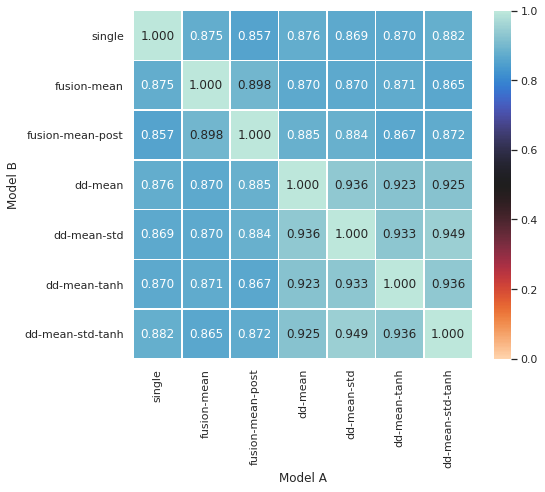

In [28]:
make_heatplot(df_kappas, 'Full')
plt.tight_layout()
plt.savefig('maa_full.png', dpi=300)

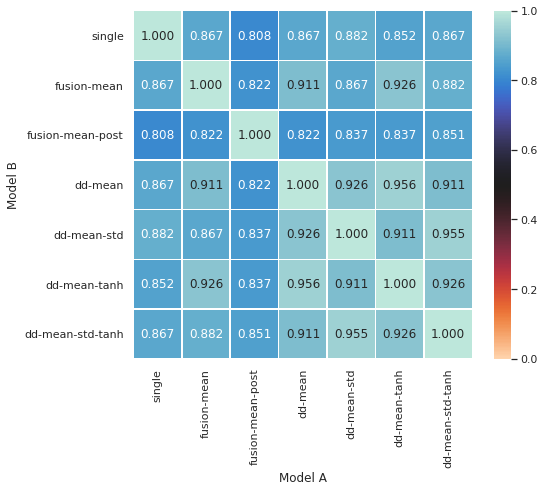

In [29]:
make_heatplot(df_kappas, 'Humerus')
plt.tight_layout()
plt.savefig('maa_humerus.png', dpi=300)